In [1]:
pip install tensorflow==2.17.1 keras==3.5.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
print(tf.__version__)

2.17.1


In [4]:
# Konfigurasi dataset
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 54

In [5]:
# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/train',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/validation',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/test',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

class_names = test_ds.class_names

Found 8478 files belonging to 54 classes.
Found 1782 files belonging to 54 classes.
Found 1782 files belonging to 54 classes.


In [6]:
for images, labels in train_ds.take(1):
    print("Image dtype:", images.dtype)
    print("Label dtype:", labels.dtype)

Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomZoom(0.2),
    layers.RandomFlip('horizontal')
])

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, augment=False):
  # Normalization all datasets.
  ds = ds.map(lambda x, y: (x, y), 
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [10]:
base_model = MobileNetV3Small(input_shape=(224, 224, 3), weights='imagenet', include_top=False, include_preprocessing=True)

base_model.trainable = False

In [11]:
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │        13,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,101,734 (4.20 MB)

 Trainable params: 162,102 (633.21 KB)

 Non-trainable params: 939,632 (3.58 MB)

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(
      train_ds,
      epochs=EPOCHS,
      verbose=2,
      validation_data=val_ds)

Epoch 1/10
265/265 - 14s - 53ms/step - accuracy: 0.5690 - loss: 1.6755 - val_accuracy: 0.8939 - val_loss: 0.4526
Epoch 2/10
265/265 - 11s - 41ms/step - accuracy: 0.8247 - loss: 0.6401 - val_accuracy: 0.9220 - val_loss: 0.2893
Epoch 3/10
265/265 - 11s - 41ms/step - accuracy: 0.8669 - loss: 0.4758 - val_accuracy: 0.9366 - val_loss: 0.2326
Epoch 4/10
265/265 - 11s - 43ms/step - accuracy: 0.8892 - loss: 0.3891 - val_accuracy: 0.9304 - val_loss: 0.2400
Epoch 5/10
265/265 - 12s - 44ms/step - accuracy: 0.8989 - loss: 0.3412 - val_accuracy: 0.9439 - val_loss: 0.1964
Epoch 6/10
265/265 - 12s - 44ms/step - accuracy: 0.9053 - loss: 0.3172 - val_accuracy: 0.9444 - val_loss: 0.1908
Epoch 7/10
265/265 - 12s - 44ms/step - accuracy: 0.9138 - loss: 0.2898 - val_accuracy: 0.9377 - val_loss: 0.1869
Epoch 8/10
265/265 - 12s - 44ms/step - accuracy: 0.9199 - loss: 0.2617 - val_accuracy: 0.9416 - val_loss: 0.1942
Epoch 9/10
265/265 - 20s - 77ms/step - accuracy: 0.9302 - loss: 0.2369 - val_accuracy: 0.9450 - 

In [14]:
results = pd.DataFrame(history.history)
print(results)

   accuracy      loss  val_accuracy  val_loss
0  0.569002  1.675514      0.893939  0.452589
1  0.824723  0.640073      0.921998  0.289286
2  0.866950  0.475826      0.936588  0.232600
3  0.889243  0.389143      0.930415  0.239979
4  0.898915  0.341196      0.943883  0.196434
5  0.905284  0.317184      0.944444  0.190788
6  0.913777  0.289787      0.937710  0.186893
7  0.919910  0.261708      0.941639  0.194156
8  0.930172  0.236943      0.945006  0.188869
9  0.928403  0.242530      0.949495  0.174031


In [15]:
model.evaluate(test_ds, verbose=2)

56/56 - 2s - 31ms/step - accuracy: 0.9456 - loss: 0.1755


[0.17550669610500336, 0.9455667734146118]

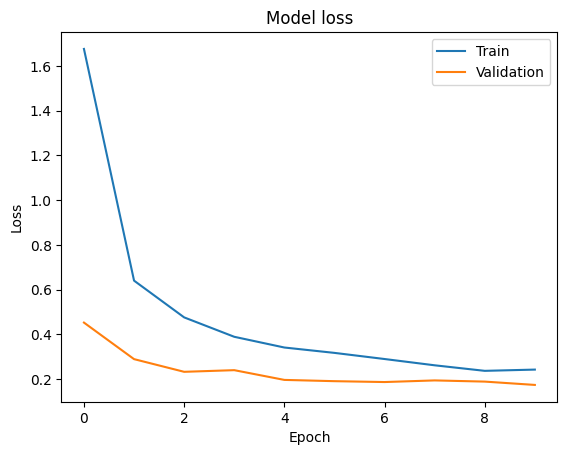

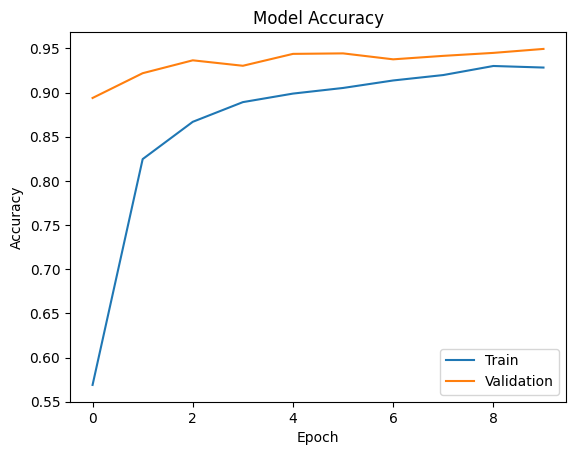

In [16]:
# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

56/56 - 3s - 53ms/step


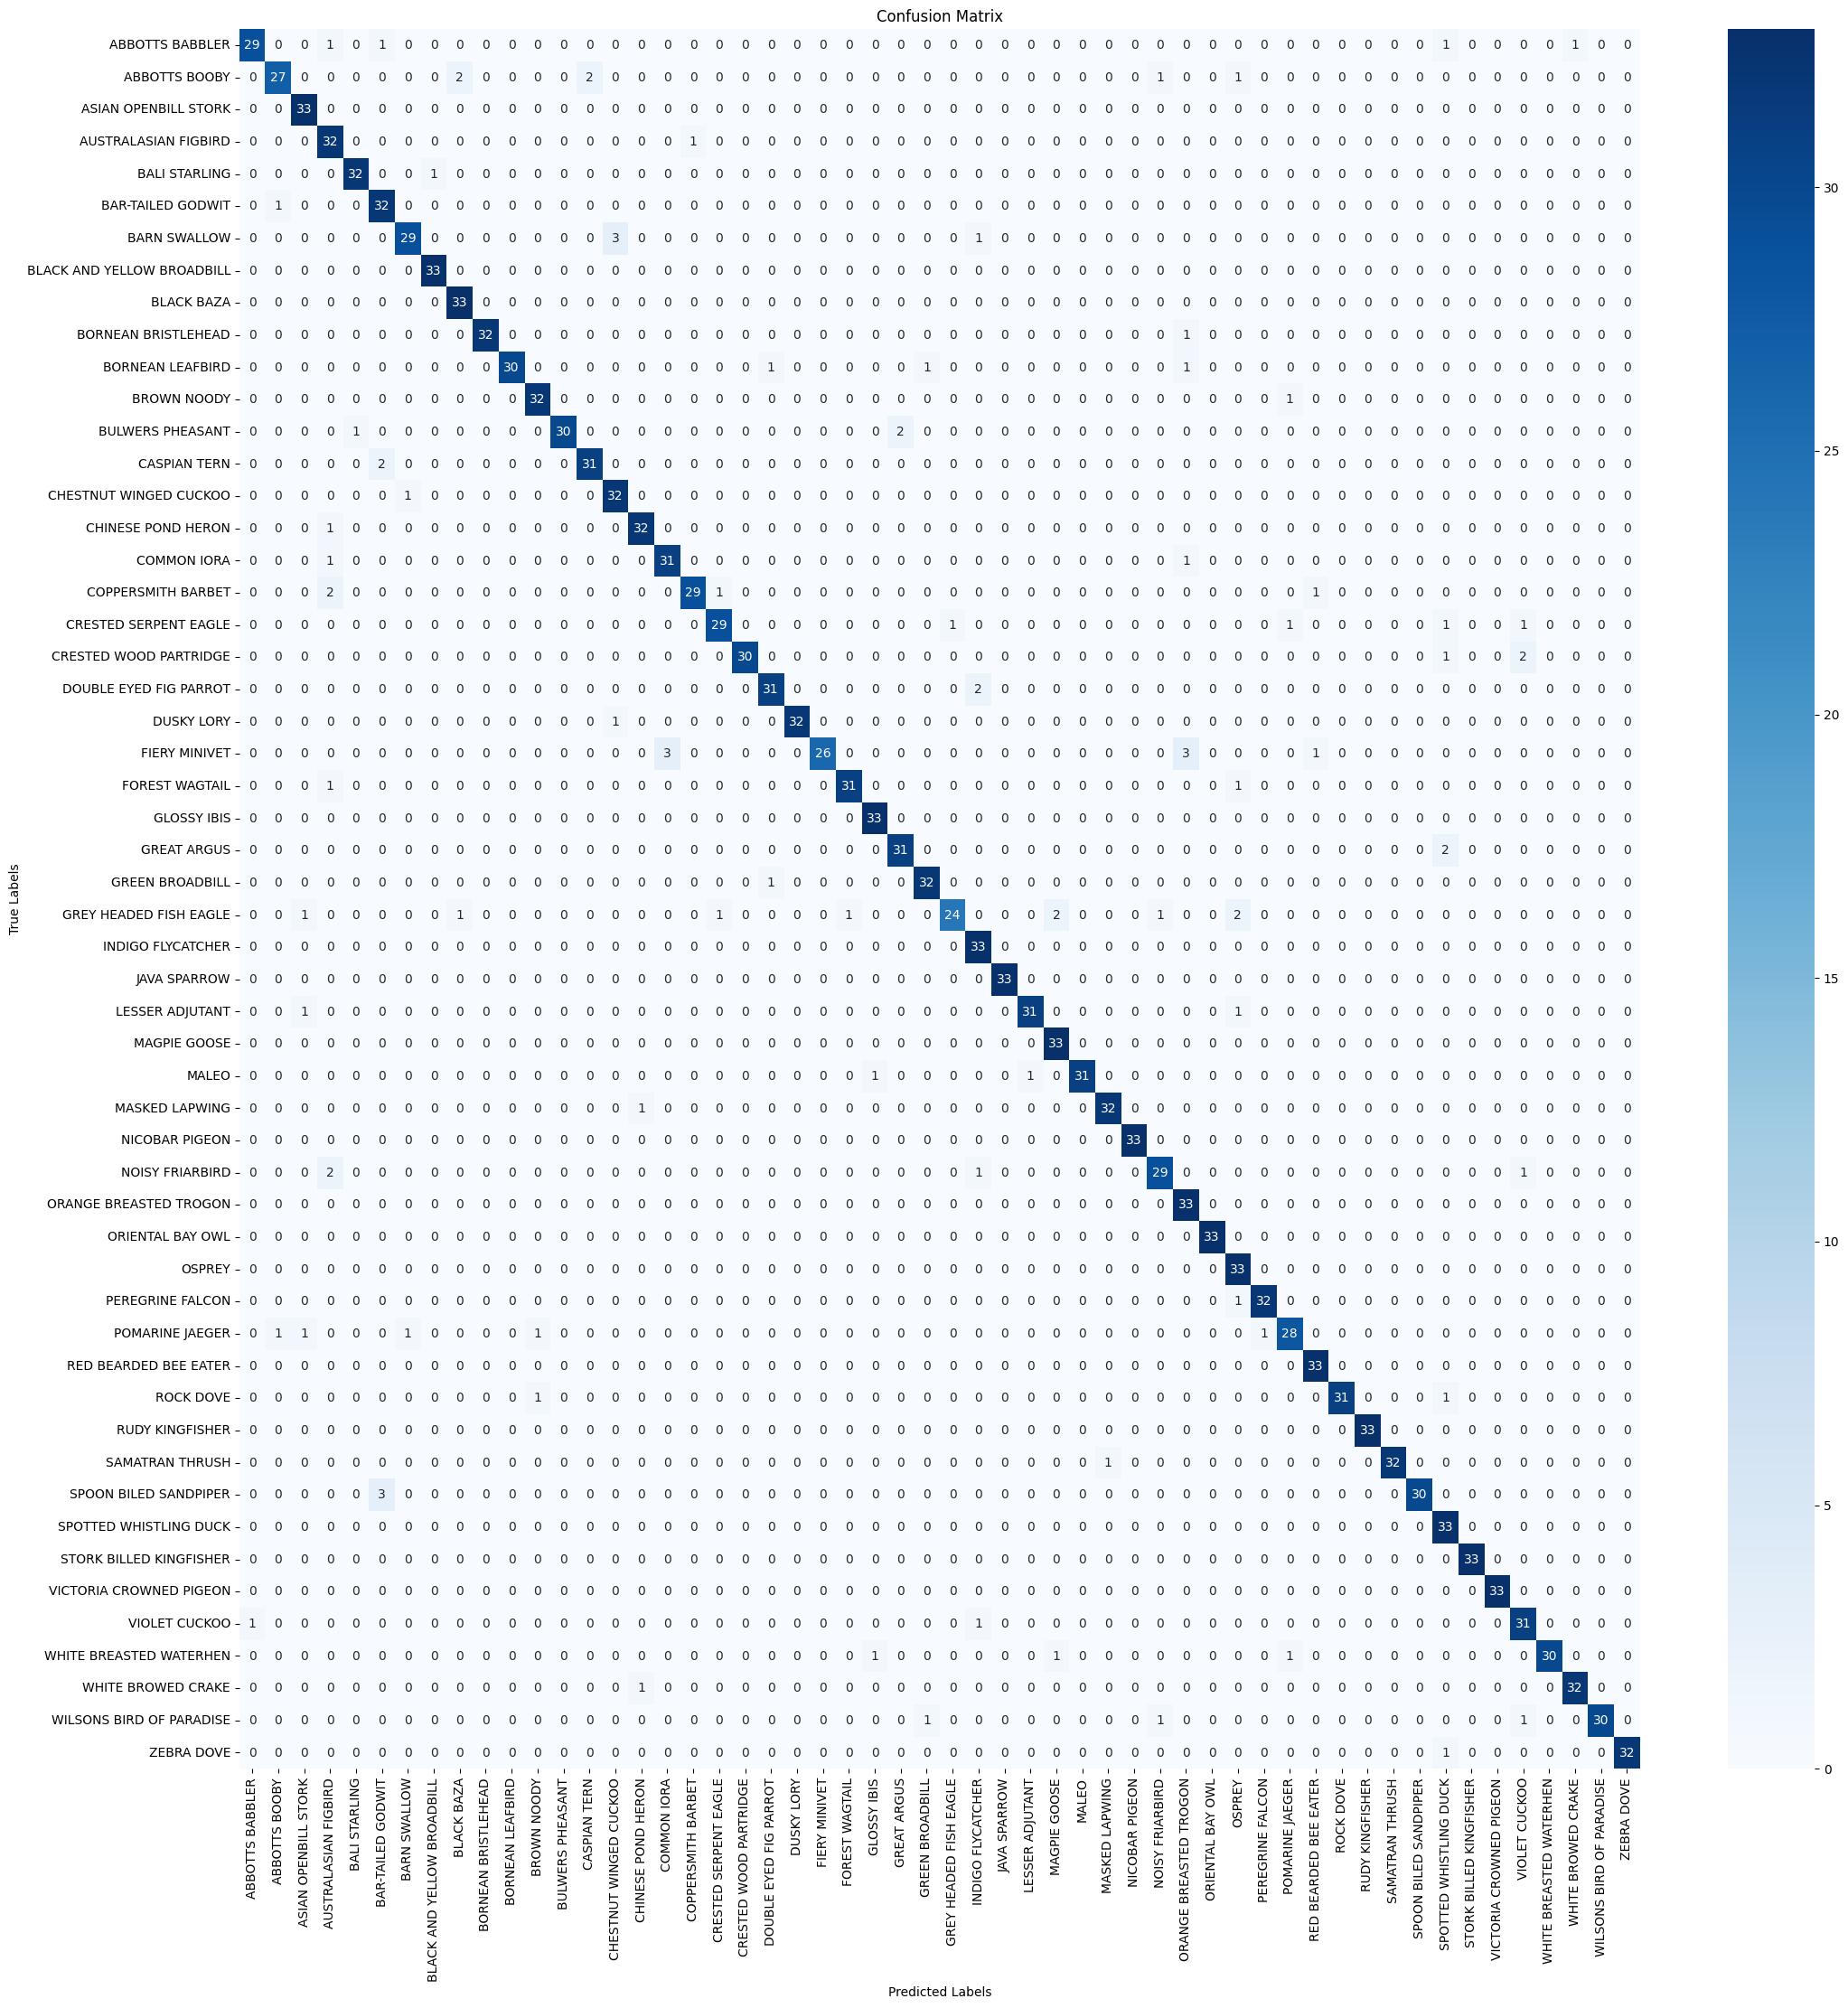

In [17]:
# Confusion matrix dan classification report
true_labels = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds, verbose=2)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(true_labels, y_pred_labels)

plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print('Classification Report:')
print(classification_report(true_labels, y_pred_labels, target_names=class_names))

Classification Report:
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.97      0.88      0.92        33
             ABBOTTS BOOBY       0.93      0.82      0.87        33
      ASIAN OPENBILL STORK       0.92      1.00      0.96        33
      AUSTRALASIAN FIGBIRD       0.80      0.97      0.88        33
             BALI STARLING       0.97      0.97      0.97        33
         BAR-TAILED GODWIT       0.84      0.97      0.90        33
              BARN SWALLOW       0.94      0.88      0.91        33
BLACK AND YELLOW BROADBILL       0.97      1.00      0.99        33
                BLACK BAZA       0.92      1.00      0.96        33
       BORNEAN BRISTLEHEAD       1.00      0.97      0.98        33
          BORNEAN LEAFBIRD       1.00      0.91      0.95        33
               BROWN NOODY       0.94      0.97      0.96        33
          BULWERS PHEASANT       1.00      0.91      0.95        33
              CASPIAN TE

In [19]:
# Confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)
labels = class_names  # list nama kelas
results = []

# Inisialisasi untuk rata-rata
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
total_test_data = 0

# Hitung metrik per kelas
for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    total = TP + FN
    total_test_data += total

    # Hitung metrik
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Akumulasi untuk rata-rata
    total_precision += precision
    total_recall += recall
    total_f1 += f1_score

    results.append({
        'Class': label,
        'Total': total,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1_score, 4)
    })

# Hitung rata-rata
n_classes = len(labels)
avg_precision = total_precision / n_classes
avg_recall = total_recall / n_classes
avg_f1 = total_f1 / n_classes

# Tambahkan baris rata-rata ke DataFrame
results.append({
    'Class': 'Average',
    'Total': total_test_data,
    'TP': '-',
    'FP': '-',
    'FN': '-',
    'TN': '-',
    'Precision': round(avg_precision, 4),
    'Recall': round(avg_recall, 4),
    'F1-Score': round(avg_f1, 4)
})

# Buat DataFrame
metrics_df = pd.DataFrame(results)
metrics_df.to_excel('hasilmodel/cnn+mobilenet/small/confusion_metrics_mobilenetv3small.xlsx', index=False)

In [20]:
# Confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)

# Inisialisasi list untuk hasil
labels = class_names
results = []

# Hitung TP, FP, FN, TN untuk setiap kelas
for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    results.append({
        'Class': label,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    })

# Buat dataframe
metrics_df = pd.DataFrame(results)

# Tampilkan tabel
print(metrics_df)

metrics_df.to_excel('hasilmodel/cnn+mobilenet/small/tidaklengkapconfusion_metrics_mobilenetv3small.xlsx', index=False)

                         Class  TP  FP  FN    TN
0              ABBOTTS BABBLER  29   1   4  1748
1                ABBOTTS BOOBY  27   2   6  1747
2         ASIAN OPENBILL STORK  33   3   0  1746
3         AUSTRALASIAN FIGBIRD  32   8   1  1741
4                BALI STARLING  32   1   1  1748
5            BAR-TAILED GODWIT  32   6   1  1743
6                 BARN SWALLOW  29   2   4  1747
7   BLACK AND YELLOW BROADBILL  33   1   0  1748
8                   BLACK BAZA  33   3   0  1746
9          BORNEAN BRISTLEHEAD  32   0   1  1749
10            BORNEAN LEAFBIRD  30   0   3  1749
11                 BROWN NOODY  32   2   1  1747
12            BULWERS PHEASANT  30   0   3  1749
13                CASPIAN TERN  31   2   2  1747
14      CHESTNUT WINGED CUCKOO  32   4   1  1745
15          CHINESE POND HERON  32   2   1  1747
16                 COMMON IORA  31   3   2  1746
17          COPPERSMITH BARBET  29   1   4  1748
18       CRESTED SERPENT EAGLE  29   2   4  1747
19      CRESTED WOOD

In [21]:
model.save('hasilmodel/cnn+mobilenet/small/mobilenetv3small.keras')

In [22]:
# Ambil nama folder dalam dataset/train sebagai label
class_names = sorted(os.listdir('dataset/train'))

# Simpan label ke dalam file labels.txt
with open('hasilmodel/cnn+mobilenet/small/labelssmall.txt', 'w') as f:
    for label in class_names:
        f.write(f'{label}\n')

print('Label mapping saved to labelssmall.txt')

Label mapping saved to labelssmall.txt
